In [1]:
import numpy as np
import re
from IPython.display import clear_output

from keras.layers import Dense, LSTM, Input, Embedding, Dropout
from keras.utils import np_utils
from keras.models import Model, load_model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import LambdaCallback

Using TensorFlow backend.


In [2]:
load_saved_model = False
train_model = False

In [3]:
token_type = 'word'

In [4]:
#load in the text and perform some cleanup

seq_length = 20

filename = "./data/aesop/data.txt"

with open(filename, encoding='utf-8-sig') as f:
    text = f.read()
    
    
#removing text before and after the main stories
start = text.find("THE FOX AND THE GRAPES\n\n\n")
end = text.find("ILLUSTRATIONS\n\n\n[")
text = text[start:end]

In [5]:
start_story = '| ' * seq_length
    
text = start_story + text
text = text.lower()
text = text.replace('\n\n\n\n\n', start_story)
text = text.replace('\n', ' ')
text = re.sub('  +', '. ', text).strip()
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text)
text = re.sub('\s{2,}', ' ', text)

In [6]:
len(text)

213694

In [7]:
text

' | | | | | | | | | | | | | | | | | | | | the fox and the grapes . a hungry fox saw some fine bunches of grapes hanging from a vine that was trained along a high trellis , and did his best to reach them by jumping as high as he could into the air . but it was all in vain , for they were just out of reach : so he gave up trying , and walked away with an air of dignity and unconcern , remarking , " i thought those grapes were ripe , but i see now they are quite sour . " | | | | | | | | | | | | | | | | | | | | the goose that laid the golden eggs . a man and his wife had the good fortune to possess a goose which laid a golden egg every day . lucky though they were , they soon began to think they were not getting rich fast enough , and , imagining the bird must be made of gold inside , they decided to kill it in order to secure the whole store of precious metal at once . but when they cut it open they found it was just like any other goose . thus , they neither got rich all at once , as the

In [8]:

if token_type == 'word':
    tokenizer = Tokenizer(char_level = False, filters = '')
else:
    tokenizer = Tokenizer(char_level = True, filters = '', lower = False)
    
    
tokenizer.fit_on_texts([text])

total_words = len(tokenizer.word_index) + 1

token_list = tokenizer.texts_to_sequences([text])[0]


In [9]:
total_words

4170

In [10]:
print(tokenizer.word_index)
print(token_list)

{'|': 1, ',': 2, 'the': 3, 'and': 4, '.': 5, 'a': 6, 'to': 7, '"': 8, 'of': 9, 'he': 10, 'his': 11, 'was': 12, 'you': 13, 'in': 14, 'him': 15, 'it': 16, 'for': 17, 'i': 18, 'but': 19, 'that': 20, 'with': 21, 'said': 22, 'they': 23, 'at': 24, 'as': 25, 'when': 26, 'on': 27, 'so': 28, 'by': 29, ':': 30, 'one': 31, 'had': 32, ';': 33, 'be': 34, 'them': 35, 'up': 36, 'all': 37, 'who': 38, '-': 39, 'her': 40, 'my': 41, 'is': 42, 'out': 43, 'me': 44, 'not': 45, 'your': 46, 'were': 47, 'which': 48, 'have': 49, 'their': 50, 'no': 51, 'lion': 52, 'she': 53, 'if': 54, 'into': 55, 'fox': 56, 'an': 57, 'what': 58, 'ass': 59, '!': 60, 'time': 61, 'from': 62, 'are': 63, 'came': 64, '?': 65, 'man': 66, 'do': 67, 'about': 68, 'there': 69, 'wolf': 70, 'then': 71, 'upon': 72, 'himself': 73, 'this': 74, 'day': 75, 'would': 76, 'some': 77, 'once': 78, 'will': 79, 'very': 80, 'went': 81, 'well': 82, 'than': 83, 'down': 84, 'replied': 85, 'got': 86, 'off': 87, 'could': 88, 'away': 89, 'see': 90, 'good': 91,

In [11]:
def generate_sequences(token_list, step):
    
    X = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        X.append(token_list[i: i + seq_length])
        y.append(token_list[i + seq_length])
    

    y = np_utils.to_categorical(y, num_classes = total_words)
    
    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")
    
    return X, y, num_seq

step = 1
seq_length = 20

X, y, num_seq = generate_sequences(token_list, step)

X = np.array(X)
y = np.array(y)


Number of sequences: 50399 



In [12]:
X.shape

(50399, 20)

In [13]:
y.shape

(50399, 4170)

## Define the LSTM model

In [14]:
if load_saved_model:
    # model = load_model('./saved_models/lstm_aesop_1.h5')
    model = load_model('./saved_models/aesop_dropout_100.h5')

else:

    n_units = 256
    embedding_size = 100

    text_in = Input(shape = (None,))
    embedding = Embedding(total_words, embedding_size)
    x = embedding(text_in)
    x = LSTM(n_units)(x)
    # x = Dropout(0.2)(x)
    text_out = Dense(total_words, activation = 'softmax')(x)

    model = Model(text_in, text_out)

    opti = RMSprop(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opti)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         417000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 4170)              1071690   
Total params: 1,854,258
Trainable params: 1,854,258
Non-trainable params: 0
_________________________________________________________________


In [16]:
def sample_with_temp(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def generate_text(seed_text, next_words, model, max_sequence_len, temp):
    output_text = seed_text
    
    seed_text = start_story + seed_text
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))
        
        probs = model.predict(token_list, verbose=0)[0]
        y_class = sample_with_temp(probs, temperature = temp)
        
        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class]
            
        if output_word == "|":
            break
            
        if token_type == 'word':
            output_text += output_word + ' '
            seed_text += output_word + ' '
        else:
            output_text += output_word + ' '
            seed_text += output_word + ' '
            
            
    return output_text

In [17]:
def on_epoch_end(epoch, logs):
    seed_text = ""
    gen_words = 500

    print('Temp 0.2')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.2))
    print('Temp 0.33')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.33))
    print('Temp 0.5')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.5))
    print('Temp 1.0')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 1))
    
if train_model:
    epochs = 1000
    batch_size = 32
    num_batches = int(len(X) / batch_size)
    callback = LambdaCallback(on_epoch_end=on_epoch_end)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         417000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 4170)              1071690   
Total params: 1,854,258
Trainable params: 1,854,258
Non-trainable params: 0
_________________________________________________________________


In [19]:
seed_text = "the frog and the snake . "
gen_words = 500
temp = 0.1

print (generate_text(seed_text, gen_words, model, seq_length, temp))

the frog and the snake . stopped slaughter dullness overjoyed tiny chatter victory water's death's care eggs proposals pomegranate horseman pretty flatly overtook likely suppose harmless derided falls ash listening abuse humming squeak suspected unwelcome agree smallest discussed fade spend belaboured turning returned feverish bulk legs worthy image refuge cattle swooped ugly statues add water's observed fuller knew daily bed free self kissed revive unjust produce spared murderous overripe knife concerned plunder proceeded olive service vine dog growing attempting universal denying o pickings frisk ant enmity mounting ages poverty spoil sweetness hercules violent bungling leaped tools pelted heavens wasted numb finish sling snapped house boots conversed settle crew helpless whisper armful wonder answer venus emerald prowess restored need kitchen mingled unlucky favour something ease keeping ugly understand frisk deafening attacks inflammable lot eagle seems rubbed mounted owner's you s

In [20]:
def generate_human_led_text(model, max_sequence_len):
    
    output_text = ''
    seed_text = start_story
    
    while 1:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))
        
        probs = model.predict(token_list, verbose=0)[0]

        top_10_idx = np.flip(np.argsort(probs)[-10:])
        top_10_probs = [probs[x] for x in top_10_idx]
        top_10_words = tokenizer.sequences_to_texts([[x] for x in top_10_idx])
        
        for prob, word in zip(top_10_probs, top_10_words):
            print('{:<6.1%} : {}'.format(prob, word))

        chosen_word = input()
                
        if chosen_word == '|':
            break  
        
        seed_text += chosen_word + ' '
        output_text += chosen_word + ' '
        
        clear_output()

        print (output_text)

In [21]:
generate_human_led_text(model, 10)

the owl sat on the branch fox is busy someone  tries to be kind 
0.0%   : feelings
0.0%   : nightingale
0.0%   : became
0.0%   : drag
0.0%   : working
0.0%   : noble
0.0%   : filched
0.0%   : where
0.0%   : flapping
0.0%   : intercourse
|


KeyboardInterrupt: 

In [20]:
# model.save('./saved_models/aesop_no_dropout_100.h5')

In [26]:
# attempt to straighten out the issues with seq2seq
# Keras API: https://keras.io/guides/functional_api/

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
import re

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#nltk
import nltk

#stop-words
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))

# tokenizing
from nltk import word_tokenize,sent_tokenize

#keras
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, TimeDistributed
from keras.models import Model

def vocab_creator(text_lists, vocab_size):
    '''create vocabulary and return wrd-id and id-wrd mappings'''
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(text_lists)
    dictionary = tokenizer.word_index
    word2idx = {}
    idx2word = {}
    for k, v in dictionary.items():
        if v < vocab_size:
            word2idx[k] = v
            idx2word[v] = k
        if v >= vocab_size-1:
            continue
    return word2idx, idx2word

def txt2seq(txt, vocab):
    '''tokenize text and return list of tokens'''
    res = []
    for sent in txt: # txt is a list of sentences
        res.append([vocab[0][wrd] for wrd in sent.split()])
    return res

sample_text_1="bitty bought a bit of butter"
sample_text_2="but the bit of butter was a bit bitter"
sample_text_3="so she bought some better butter to make the bitter butter better"

corp = [sample_text_1, sample_text_2, sample_text_3] # corpus
no_docs = len(corp) # number of documents in corpus

vocab_size = 50 # size of vocabulary
#vocab = vocab_creator(text_lists, vocab_size)

encod_corp = []
for i, doc in enumerate(corp): # docs in corpus
    encod_corp.append(one_hot(doc,50))
    print("The encoding for document", i+1, " is : ", one_hot(doc,50))
    
# length of maximum document. will be nedded whenever create embeddings for the words
maxlen = -1
for doc in corp: # docs in corpus
    tokens = nltk.word_tokenize(doc) # tokenize document
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is : ", maxlen)

# now to create embeddings all of our docs need to be of same length. hence we can pad the docs with zeros.
pad_corp = pad_sequences(encod_corp, maxlen = maxlen, padding = 'post', value = 0.0)
print("No of padded documents: ", len(pad_corp))

for i, doc in enumerate(pad_corp):
     print("The padded encoding for document", i+1, " is : ", doc)

print('vocab_size: ', vocab_size)
print('maxlen: ', maxlen)

# clear old model
keras.backend.clear_session()
        
encoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('encoder_inputs: ', np.shape(encoder_inputs)) # (None, 12)
#encoder_embedding = embed_layer(encoder_inputs)
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(encoder_inputs)
print('encoder_embedding: ', np.shape(encoder_embedding)) # (None, 12, 8)
HIDDEN_DIM = 3
encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)

encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
print('encoder_outputs: ', np.shape(encoder_outputs)) # (None, 3)
print('state_h: ', np.shape(state_h)) # (None, 3)
print('state_c: ', np.shape(state_c)) # (None, 3)
decoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('decoder_inputs: ', np.shape(decoder_inputs)) # (None, 12)
#decoder_embedding = embed_layer(decoder_inputs)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(decoder_inputs)
print('decoder_embedding: ', np.shape(decoder_embedding)) # (None, 12, 8)
decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)

decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c]) # no need to return hidden states
print('dec_out: ', np.shape(decoder_outputs)) # (None, 12, 3)

# dense_layer = Dense(VOCAB_SIZE, activation='softmax')
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.summary()
#keras.utils.plot_model(model, "seq2seq_t0.png", show_shapes=True)

print(outputs.shape)
print('outputs: ', np.shape(outputs)) # (None, 12, 50)

data_path = 'D:\BernieData\DeepL\data'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)

'''model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid_data) // (batch_size*num_steps), callbacks=[checkpointer])'''

# Actually training the model: (x=input data, y=target data)
# see https://www.tensorflow.org/api_docs/python/tf/keras/Model

# need to reshape to (samples, 12)

print('predict: ', np.shape(pad_corp)) # (3, 12)
print('predict: ', np.shape(pad_corp[0])) # (12, )
print(pad_corp[0])

x_train = np.array([pad_corp[i % 3] for i in range(12)]) # 12 samples generated
y_train = np.ones((12, 12, 50)) # shape (12, 50)
print('x_train: ', np.shape(x_train)) # (12,)
print('y_train: ', np.shape(y_train)) # (12,)

print(x_train)
print(y_train)

model.fit([x_train, x_train], y_train, epochs=1)

x_test = np.array([pad_corp[0] for i in range(1)]) # 1 sample generated
print(x_test)
prediction = model.predict([x_test, x_test])
print(prediction)
print(np.shape(prediction))

'''model = load_model(data_path + "\model-40.hdf5")
dummy_iters = 40
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,
                                                     skip_step=1)
print("Training data:")
for i in range(dummy_iters):
    dummy = next(example_training_generator.generate())
num_predict = 10
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "
for i in range(num_predict):
    data = next(example_training_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "
    pred_print_out += reversed_dictionary[predict_word] + " "
print(true_print_out)
print(pred_print_out)'''

The encoding for document 1  is :  [19, 6, 9, 32, 1, 21]
The encoding for document 2  is :  [43, 28, 32, 1, 21, 12, 9, 32, 44]
The encoding for document 3  is :  [20, 15, 6, 45, 49, 21, 21, 10, 28, 44, 21, 49]
The maximum number of words in any document is :  12
No of padded documents:  3
The padded encoding for document 1  is :  [19  6  9 32  1 21  0  0  0  0  0  0]
The padded encoding for document 2  is :  [43 28 32  1 21 12  9 32 44  0  0  0]
The padded encoding for document 3  is :  [20 15  6 45 49 21 21 10 28 44 21 49]
vocab_size:  50
maxlen:  12
encoder_inputs:  (None, 12)
encoder_embedding:  (None, 12, 8)
encoder_outputs:  (None, 3)
state_h:  (None, 3)
state_c:  (None, 3)
decoder_inputs:  (None, 12)
decoder_embedding:  (None, 12, 8)
dec_out:  (None, 12, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (In

'model = load_model(data_path + "\\model-40.hdf5")\ndummy_iters = 40\nexample_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,\n                                                     skip_step=1)\nprint("Training data:")\nfor i in range(dummy_iters):\n    dummy = next(example_training_generator.generate())\nnum_predict = 10\ntrue_print_out = "Actual words: "\npred_print_out = "Predicted words: "\nfor i in range(num_predict):\n    data = next(example_training_generator.generate())\n    prediction = model.predict(data[0])\n    predict_word = np.argmax(prediction[:, num_steps-1, :])\n    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "\n    pred_print_out += reversed_dictionary[predict_word] + " "\nprint(true_print_out)\nprint(pred_print_out)'

In [1]:
# attempt to straighten out the issues with seq2seq
# Keras API: https://keras.io/guides/functional_api/

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
import re

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#nltk
import nltk

#stop-words
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))

# tokenizing
from nltk import word_tokenize,sent_tokenize

#keras
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, TimeDistributed
from keras.models import Model

def vocab_creator(text_lists, vocab_size):
    '''create vocabulary and return wrd-id and id-wrd mappings'''
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(text_lists)
    dictionary = tokenizer.word_index
    word2idx = {}
    idx2word = {}
    for k, v in dictionary.items():
        if v < vocab_size:
            word2idx[k] = v
            idx2word[v] = k
        if v >= vocab_size-1:
            continue
    return word2idx, idx2word

def txt2seq(txt, vocab):
    '''tokenize text and return list of tokens'''
    res = []
    for sent in txt: # txt is a list of sentences
        res.append([vocab[0][wrd] for wrd in sent.split()])
    return res

sample_text_1="bitty bought a bit of butter"
sample_text_2="but the bit of butter was a bit bitter"
sample_text_3="so she bought some better butter to make the bitter butter better"

corp = [sample_text_1, sample_text_2, sample_text_3] # corpus
no_docs = len(corp) # number of documents in corpus

vocab_size = 50 # size of vocabulary
#vocab = vocab_creator(text_lists, vocab_size)

encod_corp = []
for i, doc in enumerate(corp): # docs in corpus
    encod_corp.append(one_hot(doc,50))
    print("The encoding for document", i+1, " is : ", one_hot(doc,50))
    
# length of maximum document. will be nedded whenever create embeddings for the words
maxlen = -1
for doc in corp: # docs in corpus
    tokens = nltk.word_tokenize(doc) # tokenize document
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is : ", maxlen)

# now to create embeddings all of our docs need to be of same length. hence we can pad the docs with zeros.
pad_corp = pad_sequences(encod_corp, maxlen = maxlen, padding = 'post', value = 0.0)
print("No of padded documents: ", len(pad_corp))

for i, doc in enumerate(pad_corp):
     print("The padded encoding for document", i+1, " is : ", doc)

print('vocab_size: ', vocab_size)
print('maxlen: ', maxlen)

# clear old model
keras.backend.clear_session()
        
encoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('encoder_inputs: ', np.shape(encoder_inputs)) # (None, 12)
#encoder_embedding = embed_layer(encoder_inputs)
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(encoder_inputs)
print('encoder_embedding: ', np.shape(encoder_embedding)) # (None, 12, 8)
HIDDEN_DIM = 3
encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)

encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
print('encoder_outputs: ', np.shape(encoder_outputs)) # (None, 3)
print('state_h: ', np.shape(state_h)) # (None, 3)
print('state_c: ', np.shape(state_c)) # (None, 3)
decoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('decoder_inputs: ', np.shape(decoder_inputs)) # (None, 12)
#decoder_embedding = embed_layer(decoder_inputs)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(decoder_inputs)
print('decoder_embedding: ', np.shape(decoder_embedding)) # (None, 12, 8)
decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)

decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c]) # no need to return hidden states
print('dec_out: ', np.shape(decoder_outputs)) # (None, 12, 3)

# dense_layer = Dense(VOCAB_SIZE, activation='softmax')
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.summary()
#keras.utils.plot_model(model, "seq2seq_t0.png", show_shapes=True)

print(outputs.shape)
print('outputs: ', np.shape(outputs)) # (None, 12, 50)

data_path = 'D:\BernieData\DeepL\data'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)

'''model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid_data) // (batch_size*num_steps), callbacks=[checkpointer])'''

# Actually training the model: (x=input data, y=target data)
# see https://www.tensorflow.org/api_docs/python/tf/keras/Model

# need to reshape to (samples, 12)

print('predict: ', np.shape(pad_corp)) # (3, 12)
print('predict: ', np.shape(pad_corp[0])) # (12, )
print(pad_corp[0])

x_train = np.array([pad_corp[i % 3] for i in range(12)]) # 12 samples generated
y_train = np.ones((12, 12, 50)) # shape (12, 50)
print('x_train: ', np.shape(x_train)) # (12,)
print('y_train: ', np.shape(y_train)) # (12,)

print(x_train)
print(y_train)

model.fit([x_train, x_train], y_train, epochs=1)

x_test = np.array([pad_corp[0] for i in range(1)]) # 1 sample generated
print(x_test)
prediction = model.predict([x_test, x_test])
print(prediction)
print(np.shape(prediction))

'''model = load_model(data_path + "\model-40.hdf5")
dummy_iters = 40
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,
                                                     skip_step=1)
print("Training data:")
for i in range(dummy_iters):
    dummy = next(example_training_generator.generate())
num_predict = 10
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "
for i in range(num_predict):
    data = next(example_training_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "
    pred_print_out += reversed_dictionary[predict_word] + " "
print(true_print_out)
print(pred_print_out)'''

Using TensorFlow backend.


The encoding for document 1  is :  [7, 34, 19, 6, 24, 7]
The encoding for document 2  is :  [21, 35, 6, 24, 7, 13, 19, 6, 2]
The encoding for document 3  is :  [5, 45, 34, 10, 39, 7, 47, 25, 35, 2, 7, 39]
The maximum number of words in any document is :  12
No of padded documents:  3
The padded encoding for document 1  is :  [ 7 34 19  6 24  7  0  0  0  0  0  0]
The padded encoding for document 2  is :  [21 35  6 24  7 13 19  6  2  0  0  0]
The padded encoding for document 3  is :  [ 5 45 34 10 39  7 47 25 35  2  7 39]
vocab_size:  50
maxlen:  12
encoder_inputs:  (None, 12)
encoder_embedding:  (None, 12, 8)
encoder_outputs:  (None, 3)
state_h:  (None, 3)
state_c:  (None, 3)
decoder_inputs:  (None, 12)
decoder_embedding:  (None, 12, 8)
dec_out:  (None, 12, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLa

'model = load_model(data_path + "\\model-40.hdf5")\ndummy_iters = 40\nexample_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,\n                                                     skip_step=1)\nprint("Training data:")\nfor i in range(dummy_iters):\n    dummy = next(example_training_generator.generate())\nnum_predict = 10\ntrue_print_out = "Actual words: "\npred_print_out = "Predicted words: "\nfor i in range(num_predict):\n    data = next(example_training_generator.generate())\n    prediction = model.predict(data[0])\n    predict_word = np.argmax(prediction[:, num_steps-1, :])\n    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "\n    pred_print_out += reversed_dictionary[predict_word] + " "\nprint(true_print_out)\nprint(pred_print_out)'

# Seq2seq without and with attention
create two models, one without and another one with attention. Test model performance on random sequences, one-hot encoded.

In [1]:
# from https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
# adapted a bit

from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.backend import clear_session

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)] # random int 0 to n_unique-1 of length

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)] # create a vector of all 0s
        vector[value] = 1 # set the current value (an int) to 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq] # returns the only 1 in all 0s

# prepare data for the LSTM (length up to cardinality, 1-hot encoded)
def get_pair(n_in, n_out, cardinality):
    # generate random sequence
    sequence_in = generate_sequence(n_in, cardinality)
    sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
    # one hot encode
    X = one_hot_encode(sequence_in, cardinality)
    y = one_hot_encode(sequence_out, cardinality)
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y

# clear sessions
clear_session()

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_epochs = 3000

# define model
model = Sequential()
model.add(LSTM(150, input_shape=(n_timesteps_in, n_features))) # encoder
model.add(RepeatVector(n_timesteps_in)) # always n_timesteps at once
model.add(LSTM(150, return_sequences=True)) # decoder
model.add(TimeDistributed(Dense(n_features, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train LSTM
for epoch in range(n_epochs):
    # generate new random sequence
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    # fit model for one epoch on this sequence
    if epoch % 100 == 0:
        model.fit(X, y, epochs=1, verbose=2) # verbose=2 full details (1: progress bar)
    else:
        model.fit(X, y, epochs=1, verbose=0) # verbose=0 is silent
    
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0) # verbose=0 is silent
    if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])): # the same?
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

# spot check some examples
for _ in range(10):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0)
    print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))

Using TensorFlow backend.


Epoch 1/1
 - 5s - loss: 3.9145 - accuracy: 0.0000e+00
Epoch 1/1
 - 0s - loss: 1.6719 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6134 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5937 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6234 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5710 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5934 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5601 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6010 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4595 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4879 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5899 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1508 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6138 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3722 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5725 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6963 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1530 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.5760 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4949 - accuracy: 1.0

In [2]:
# custom attention layer
# Keras new layers: https://keras.io/guides/making_new_layers_and_models_via_subclassing/

import tensorflow as tf
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
#from keras.layers.recurrent import Recurrent, _time_distributed_dense
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec

def _time_distributed_dense(x, w, b=None, dropout=None, # calculates the last term of eq. 1 for all the elements of the encoded sequence
                        input_dim=None, output_dim=None,
                        timesteps=None, training=None):
    """Apply `y . w + b` for every temporal slice y of x.
    # Arguments
        x: input tensor.
        w: weight matrix.
        b: optional bias vector.
        dropout: wether to apply dropout (same dropout mask
            for every temporal slice of the input).
        input_dim: integer; optional dimensionality of the input.
        output_dim: integer; optional dimensionality of the output.
        timesteps: integer; optional number of timesteps.
        training: training phase tensor or boolean.
    # Returns
        Output tensor.
    """
    if not input_dim:
        input_dim = K.shape(x)[2]
    if not timesteps:
        timesteps = K.shape(x)[1]
    if not output_dim:
        output_dim = K.shape(w)[1]

    if dropout is not None and 0. < dropout < 1.:
        # apply the same dropout pattern at every timestep
        ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
        dropout_matrix = K.dropout(ones, dropout)
        expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
        x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

    # collapse time dimension and batch dimension together
    x = K.reshape(x, (-1, input_dim))
    x = K.dot(x, w)
    if b is not None:
        x = K.bias_add(x, b)
    # reshape to 3D tensor
    if K.backend() == 'tensorflow':
        x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
        x.set_shape([None, None, output_dim])
    else:
        x = K.reshape(x, (-1, timesteps, output_dim))
    return x

tfPrint = lambda d, T: tf.Print(input_=T, data=[T, tf.shape(T)], message=d)

class AttentionDecoder(Recurrent): # layer class combines state weights and computations

    def __init__(self, units, output_dim, # called when the Layer is first instantiated
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space

        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio.
            "Neural machine translation by jointly learning to align and translate."
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences (output of our layer is a sequence)

    def build(self, input_shape): # build is called when we run Model.compile
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """

        self.batch_size, self.timesteps, self.input_dim = input_shape

        if self.stateful:
            super(AttentionDecoder, self).reset_states()

        self.states = [None, None]  # y, s

        """
            Matrices for creating the context vector (subscript a: for context vectors)
        """

        self.V_a = self.add_weight(shape=(self.units,), # self.add_weight inits weights and sets them as trainable
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate (subscripts r,z,p: for hidden states)
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units, ),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units, ),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units, ),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector (subscript o: for output)
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim, ),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)

        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True

    def call(self, x): # we need to access the entire encoded sequence within the cell
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x # only way I could find to do this was to set the sequence being fed into the cell as self.x
                        # so that we can access it later

        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = _time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)

        return super(AttentionDecoder, self).call(x)

    def get_initial_state(self, inputs):
        # apply the matrix on the first time step to get the initial s0
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))

        # from keras.layers.recurrent to initialize a vector of (batchsize, output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])

        return [y0, s0]

    def step(self, x, states): # executes the cell logic (applied to every element of the input sequence)

        ytm, stm = states # access the previous character ytm and hidden state stm which is obtained from states

        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps) # we manipulate stm to repeat it for the number of characters we have in our input sequence

        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)

        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one.
        et = K.dot(activations.tanh(_Wxstm + self._uxpb),
                   K.expand_dims(self.V_a))
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps) # use repeat to allow us to divide every time step by the respective sums
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)
        # self.x_seq and at have a “batch dimension”: need to use batch_dot to avoid doing the multiplication over that dimension

        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1) # removes left-over dimensions
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:

        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)

        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)

        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)

        # new hidden state:
        st = (1-zt)*stm + zt * s_tp

        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)

        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]

    def compute_output_shape(self, input_shape): # calculate output shapes for any given input
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)

    def get_config(self): # load the model using just a saved file
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
# visualize attention

import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from models.NMT import simpleNMT
from utils.examples import run_example
from data.reader import Vocabulary

HERE = os.path.realpath(os.path.join(os.path.realpath(__file__), '..'))

def load_examples(file_name):
    with open(file_name) as f:
        return [s.replace('\n', '') for s in f.readlines()]

# create a directory if it doesn't already exist
if not os.path.exists(os.path.join(HERE, 'attention_maps')):
    os.makedirs(os.path.join(HERE, 'attention_maps'))

SAMPLE_HUMAN_VOCAB = os.path.join(HERE, 'data', 'sample_human_vocab.json')
SAMPLE_MACHINE_VOCAB = os.path.join(HERE, 'data', 'sample_machine_vocab.json')
SAMPLE_WEIGHTS = os.path.join(HERE, 'weights', 'sample_NMT.49.0.01.hdf5')

class Visualizer(object):

    def __init__(self,
                 padding=None,
                 input_vocab=SAMPLE_HUMAN_VOCAB,
                 output_vocab=SAMPLE_MACHINE_VOCAB):
        """
            Visualizes attention maps
            :param padding: the padding to use for the sequences.
            :param input_vocab: the location of the input human
                                vocabulary file
            :param output_vocab: the location of the output 
                                 machine vocabulary file
        """
        self.padding = padding
        self.input_vocab = Vocabulary(
            input_vocab, padding=padding)
        self.output_vocab = Vocabulary(
            output_vocab, padding=padding)

    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text):
        """
            Text to visualze attention map for.
        """
        # encode the string
        d = self.input_vocab.string_to_int(text)

        # get the output sequence
        predicted_text = run_example(
            self.pred_model, self.input_vocab, self.output_vocab, text)

        text_ = list(text) + ['<eot>'] + ['<unk>'] * self.input_vocab.padding
        # get the lengths of the string
        input_length = len(text)+1
        output_length = predicted_text.index('<eot>')+1
        # get the activation map
        activation_map = np.squeeze(self.proba_model.predict(np.array([d])))[
            0:output_length, 0:input_length]

        # import seaborn as sns
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        # ax.legend(loc='best')

        f.savefig(os.path.join(HERE, 'attention_maps', text.replace('/', '')+'.pdf'), bbox_inches='tight')
        f.show()

def main(examples, args):
    print('Total Number of Examples:', len(examples))
    weights_file = os.path.expanduser(args.weights)
    print('Weights loading from:', weights_file)
    viz = Visualizer(padding=args.padding,
                     input_vocab=args.human_vocab,
                     output_vocab=args.machine_vocab)
    print('Loading models')
    pred_model = simpleNMT(trainable=False,
                           pad_length=args.padding,
                           n_chars=viz.input_vocab.size(),
                           n_labels=viz.output_vocab.size())

    pred_model.load_weights(weights_file, by_name=True)
    pred_model.compile(optimizer='adam', loss='categorical_crossentropy')

    proba_model = simpleNMT(trainable=False,
                            pad_length=args.padding,
                            n_chars=viz.input_vocab.size(),
                            n_labels=viz.output_vocab.size(),
                            return_probabilities=True)

    proba_model.load_weights(weights_file, by_name=True)
    proba_model.compile(optimizer='adam', loss='categorical_crossentropy')

    viz.set_models(pred_model, proba_model)

    print('Models loaded')

    for example in examples:
        viz.attention_map(example)

    print('Completed visualizations')


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    named_args = parser.add_argument_group('named arguments')

    named_args.add_argument('-e', '--examples', metavar='|',
                            help="""Example string/file to visualize attention map for
                                    If file, it must end with '.txt'""",
                            required=True)
    named_args.add_argument('-w', '--weights', metavar='|',
                            help="""Location of weights""",
                            required=False,
                            default=SAMPLE_WEIGHTS)
    named_args.add_argument('-p', '--padding', metavar='|',
                            help="""Length of padding""",
                            required=False, default=50, type=int)
    named_args.add_argument('-hv', '--human-vocab', metavar='|',
                            help="""Path to the human vocabulary""",
                            required=False,
                            default=SAMPLE_HUMAN_VOCAB,
                            type=str)
    named_args.add_argument('-mv', '--machine-vocab', metavar='|',
                            help="""Path to the machine vocabulary""",
                            required=False,
                            default=SAMPLE_MACHINE_VOCAB,
                            type=str)
    args = parser.parse_args()

    if '.txt' in args.examples:
        examples = load_examples(args.examples)
    else:
        examples = [args.examples]

    main(examples, args)

ModuleNotFoundError: No module named 'models'

In [3]:
# enc-dec with attention

from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
#from attention_decoder import AttentionDecoder

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
    # generate random sequence
    sequence_in = generate_sequence(n_in, cardinality)
    sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
    # one hot encode
    X = one_hot_encode(sequence_in, cardinality)
    y = one_hot_encode(sequence_out, cardinality)
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_epochs = 3000

# define model
model = Sequential()
model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
model.add(AttentionDecoder(150, n_features))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train LSTM
for epoch in range(n_epochs):
    # generate new random sequence
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    # fit model for one epoch on this sequence
    #model.fit(X, y, epochs=1, verbose=2)
    if epoch % 100 == 0:
        model.fit(X, y, epochs=1, verbose=2) # verbose=2 full details (1: progress bar)
    else:
        model.fit(X, y, epochs=1, verbose=0) # verbose=0 is silent
    
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0)
    if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

# spot check some examples
for _ in range(10):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0)
    print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))

Epoch 1/1
 - 1s - loss: 3.8895 - accuracy: 0.0000e+00
Epoch 1/1
 - 0s - loss: 1.6401 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5672 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5964 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6142 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4095 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2953 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3991 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.4832 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0915 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5776 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3041 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2989 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7747 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0497 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6496 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1925 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7903 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9189 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3050 - accuracy: 1.0

In [68]:
# custom attention layer - distributed weighted
# Keras new layers: https://keras.io/guides/making_new_layers_and_models_via_subclassing/

import tensorflow as tf
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
#from keras.layers.recurrent import Recurrent, _time_distributed_dense
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec

def _time_distributed_dense(x, w, b=None, dropout=None, # calculates the last term of eq. 1 for all the elements of the encoded sequence
                        input_dim=None, output_dim=None,
                        timesteps=None, training=None):
    """Apply `y . w + b` for every temporal slice y of x.
    # Arguments
        x: input tensor.
        w: weight matrix.
        b: optional bias vector.
        dropout: wether to apply dropout (same dropout mask
            for every temporal slice of the input).
        input_dim: integer; optional dimensionality of the input.
        output_dim: integer; optional dimensionality of the output.
        timesteps: integer; optional number of timesteps.
        training: training phase tensor or boolean.
    # Returns
        Output tensor.
    """
    if not input_dim:
        input_dim = K.shape(x)[2]
    if not timesteps:
        timesteps = K.shape(x)[1]
    if not output_dim:
        output_dim = K.shape(w)[1]

    if dropout is not None and 0. < dropout < 1.:
        # apply the same dropout pattern at every timestep
        ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
        dropout_matrix = K.dropout(ones, dropout)
        expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
        x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

    # collapse time dimension and batch dimension together
    x = K.reshape(x, (-1, input_dim))
    x = K.dot(x, w)
    if b is not None:
        x = K.bias_add(x, b)
    # reshape to 3D tensor
    if K.backend() == 'tensorflow':
        x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
        x.set_shape([None, None, output_dim])
    else:
        x = K.reshape(x, (-1, timesteps, output_dim))
    return x

tfPrint = lambda d, T: tf.Print(input_=T, data=[T, tf.shape(T)], message=d)


class AttentionQKVDecoder(Recurrent): # layer class combines state weights and computations

    def __init__(self, units, output_dim, # called when the Layer is first instantiated
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space

        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio.
            "Neural machine translation by jointly learning to align and translate."
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionQKVDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences (output of our layer is a sequence)

    def build(self, input_shape): # build is called when we run Model.compile
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """
        self.batch_size, self.timesteps, self.input_dim = input_shape
        if self.stateful:
            super(AttentionQKVDecoder, self).reset_states()
        self.states = [None, None]  # y, s

        """
            Matrices for creating the context vector (subscript a: for context vectors)
        """
        self.V_a = self.add_weight(shape=(self.units,), # self.add_weight inits weights and sets them as trainable
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate (subscripts r,z,p: for hidden states)
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units, ),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units, ),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units, ),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector (subscript o: for output)
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim, ),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        
        # for query, key, value
        '''self.W_q = self.add_weight(shape=(self.input_dim, self.timesteps), # (self.input_dim, self.timesteps),
                                   name='W_q',
                                   #initializer='uniform',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_q = self.add_weight(shape=(self.timesteps, ),
                                   name='b_q',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        self.W_k = self.add_weight(shape=(self.input_dim, self.timesteps),
                                   name='W_k',
                                   #initializer='uniform',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_k = self.add_weight(shape=(self.timesteps, ),
                                   name='b_k',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        self.W_v = self.add_weight(shape=(self.input_dim, self.timesteps),
                                   name='W_v',
                                   #initializer='uniform',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_v = self.add_weight(shape=(self.timesteps, ),
                                   name='b_v',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)'''

        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True

    def call(self, x): # we need to access the entire encoded sequence within the cell
        # a transformation from inputs to outputs (a "call", the layer's forward pass)
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x # only way I could find to do this was to set the sequence being fed into the cell as self.x
                        # so that we can access it later

        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = _time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)

        return super(AttentionQKVDecoder, self).call(x)

    def get_initial_state(self, inputs):
        # apply the matrix on the first time step to get the initial s0
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))

        # from keras.layers.recurrent to initialize a vector of (batchsize, output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])

        return [y0, s0]

    def step(self, x, states): # executes the cell logic (applied to every element of the input sequence)
        ytm, stm = states # access the previous character ytm and hidden state stm which is obtained from states
        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps) # we manipulate stm to repeat it for the number of characters we have in our input sequence

        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)

        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one
        et = K.dot(activations.tanh(_Wxstm + self._uxpb), K.expand_dims(self.V_a)) # expand: Adds a 1-sized dimension at index "axis"     
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps) # use repeat to allow us to divide every time step by the respective sums
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)
        # self.x_seq and at have a “batch dimension”: need to use batch_dot to avoid doing the multiplication over that dimension
        
        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1) # removes left-over dimensions
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:
        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)
        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)
        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)
        # new hidden state:
        st = (1-zt)*stm + zt * s_tp
        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)

        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]

    def compute_output_shape(self, input_shape): # calculate output shapes for any given input
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)

    def get_config(self): # load the model using just a saved file
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionQKVDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [83]:
# enc-dec with attention 2nd type

from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import GRU # LSTM
#from attention_decoder import AttentionDecoder

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
    # generate random sequence
    sequence_in = generate_sequence(n_in, cardinality)
    sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
    # one hot encode
    X = one_hot_encode(sequence_in, cardinality)
    y = one_hot_encode(sequence_out, cardinality)
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_epochs = 3000

# define model
model = Sequential()
#model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
model.add(GRU(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
model.add(AttentionQKVDecoder(150, n_features))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train LSTM
for epoch in range(n_epochs):
    # generate new random sequence
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    # fit model for one epoch on this sequence
    #model.fit(X, y, epochs=1, verbose=2)
    if epoch % 100 == 0:
        model.fit(X, y, epochs=1, verbose=2) # verbose=2 full details (1: progress bar)
    else:
        model.fit(X, y, epochs=1, verbose=0) # verbose=0 is silent
    
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0)
    if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

# spot check some examples
for _ in range(10):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0)
    print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))

Epoch 1/1
 - 1s - loss: 3.8933 - accuracy: 0.0000e+00
Epoch 1/1
 - 0s - loss: 1.5104 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4136 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5461 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5086 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2608 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1069 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7806 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9684 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7164 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1013 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3628 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0303 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0171 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0255 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0080 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0106 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0051 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0086 - accuracy: 1.0

## Evaluate models and compare

In [9]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
#from attention_decoder import AttentionDecoder

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
    # generate random sequence
    sequence_in = generate_sequence(n_in, cardinality)
    sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
    # one hot encode
    X = one_hot_encode(sequence_in, cardinality)
    y = one_hot_encode(sequence_out, cardinality)
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y

# define the encoder-decoder model
def baseline_model(n_timesteps_in, n_features):
    model = Sequential()
    model.add(LSTM(150, input_shape=(n_timesteps_in, n_features)))
    model.add(RepeatVector(n_timesteps_in))
    model.add(LSTM(150, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
    model = Sequential()
    model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
    model.add(AttentionDecoder(150, n_features))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# train and evaluate a model, return accuracy
def train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features):
    # train LSTM
    for epoch in range(5000):
        # generate new random sequence
        X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
        # fit model for one epoch on this sequence
        model.fit(X, y, epochs=1, verbose=0)
    # evaluate LSTM
    total, correct = 100, 0
    for _ in range(total):
        X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
        yhat = model.predict(X, verbose=0)
        if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
            correct += 1
    return float(correct)/float(total)*100.0

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 10

# evaluate encoder-decoder model
print('Encoder-Decoder Model')
results = list()
for _ in range(n_repeats):
    model = baseline_model(n_timesteps_in, n_features)
    accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features)
    results.append(accuracy)
    print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

# evaluate encoder-decoder with attention model
print('Encoder-Decoder With Attention Model')
results = list()
for _ in range(n_repeats):
    model = attention_model(n_timesteps_in, n_features)
    accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features)
    results.append(accuracy)
    print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

Encoder-Decoder Model
16.0
25.0
14.000000000000002
23.0
14.000000000000002
19.0
20.0
18.0
24.0
20.0
Mean Accuracy: 19.30%
Encoder-Decoder With Attention Model
94.0
98.0
97.0
96.0
100.0
100.0
98.0
98.0
98.0
98.0
Mean Accuracy: 97.70%


# Signal prediction

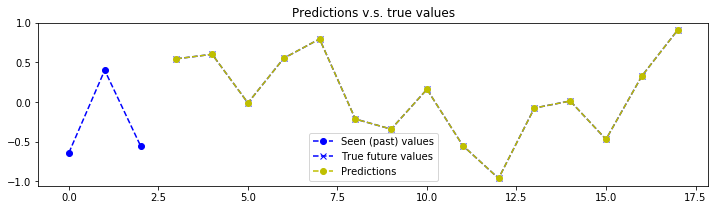

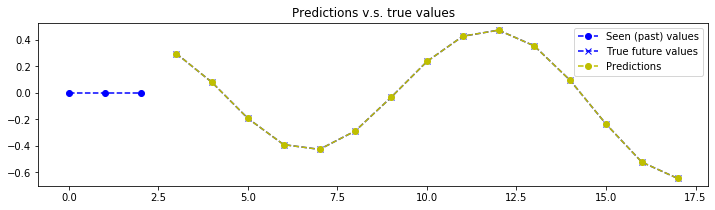

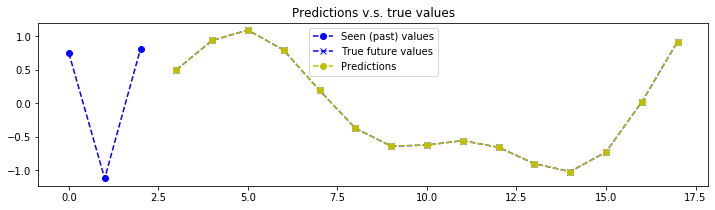

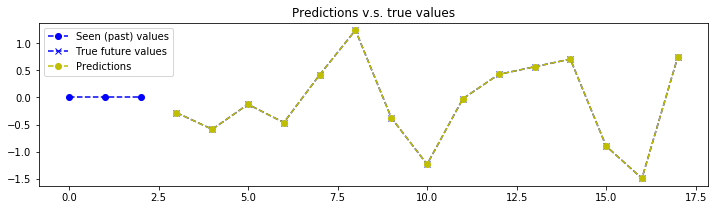

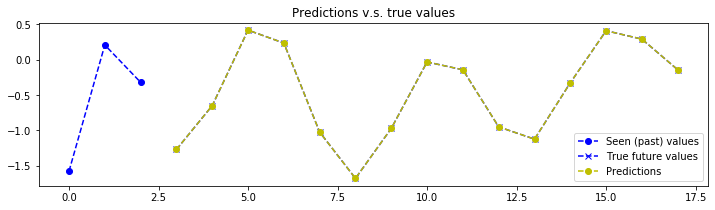

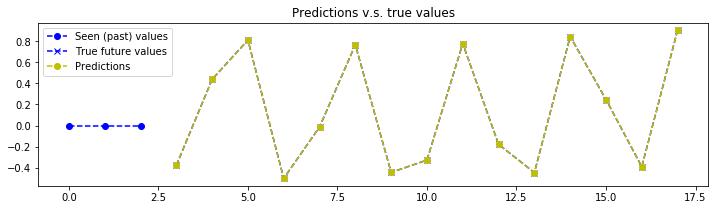

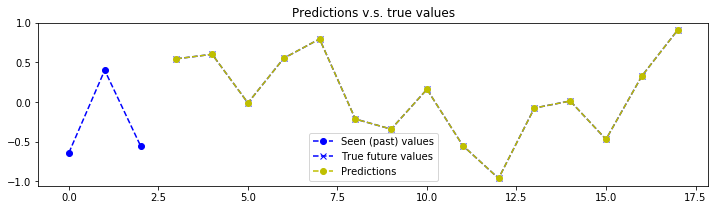

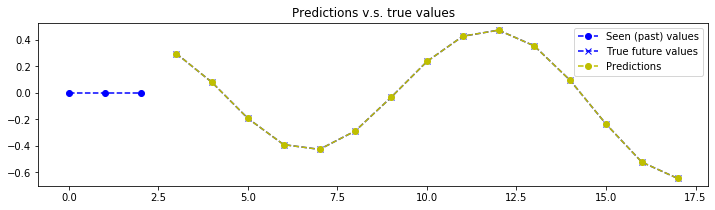

In [39]:
# from https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction

# This file contains code modified licensed under the MIT License:
# Copyright (c) 2017 Guillaume Chevalier # For more information, visit:
# https://github.com/guillaume-chevalier/seq2seq-signal-prediction
# https://github.com/guillaume-chevalier/seq2seq-signal-prediction/blob/master/LICENSE

"""Contains functions to generate artificial data for predictions as well as 
a function to plot predictions."""

import numpy as np
from matplotlib import pyplot as plt

def random_sine(batch_size, steps_per_epoch,
                input_sequence_length, target_sequence_length,
                min_frequency=0.1, max_frequency=10,
                min_amplitude=0.1, max_amplitude=1,
                min_offset=-0.5, max_offset=0.5,
                num_signals=3, seed=43):
    """Produce a batch of signals.
    The signals are the sum of randomly generated sine waves.
    Arguments
    ---------
    batch_size: Number of signals to produce.
    steps_per_epoch: Number of batches of size batch_size produced by the
        generator.
    input_sequence_length: Length of the input signals to produce.
    target_sequence_length: Length of the target signals to produce.
    min_frequency: Minimum frequency of the base signals that are summed.
    max_frequency: Maximum frequency of the base signals that are summed.
    min_amplitude: Minimum amplitude of the base signals that are summed.
    max_amplitude: Maximum amplitude of the base signals that are summed.
    min_offset: Minimum offset of the base signals that are summed.
    max_offset: Maximum offset of the base signals that are summed.
    num_signals: Number of signals that are summed together.
    seed: The seed used for generating random numbers
    
    Returns
    -------
    signals: 2D array of shape (batch_size, sequence_length)
    """
    num_points = input_sequence_length + target_sequence_length
    x = np.arange(num_points) * 2*np.pi/30

    while True:
        # Reset seed to obtain same sequences from epoch to epoch
        np.random.seed(seed)

        for _ in range(steps_per_epoch):
            signals = np.zeros((batch_size, num_points))
            for _ in range(num_signals):
                # Generate random amplitude, frequence, offset, phase 
                amplitude = (np.random.rand(batch_size, 1) * 
                            (max_amplitude - min_amplitude) +
                             min_amplitude)
                frequency = (np.random.rand(batch_size, 1) * 
                            (max_frequency - min_frequency) + 
                             min_frequency)
                offset = (np.random.rand(batch_size, 1) * 
                         (max_offset - min_offset) + 
                          min_offset)
                phase = np.random.rand(batch_size, 1) * 2 * np.pi 
                         

                signals += amplitude * np.sin(frequency * x + phase)
            signals = np.expand_dims(signals, axis=2)
            
            encoder_input = signals[:, :input_sequence_length, :]
            decoder_output = signals[:, input_sequence_length:, :]
            
            # The output of the generator must be ([encoder_input, decoder_input], [decoder_output])
            decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
            yield ([encoder_input, decoder_input], decoder_output)

def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.
    
    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """

    plt.figure(figsize=(12, 3))

    output_dim = x.shape[-1]
    for j in range(output_dim):
        past = x[:, j] 
        true = y_true[:, j]
        pred = y_pred[:, j]

        label1 = "Seen (past) values" if j==0 else "_nolegend_"
        label2 = "True future values" if j==0 else "_nolegend_"
        label3 = "Predictions" if j==0 else "_nolegend_"

        plt.plot(range(len(past)), past, "o--b",
                 label=label1)
        plt.plot(range(len(past),
                 len(true)+len(past)), true, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y",
                 label=label3)
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

if __name__ == '__main__':
    # This is an example of the plot function and the signal generator
    from matplotlib import pyplot as plt
    gen = random_sine(3, 3, 15, 15)
    for i, data in enumerate(gen):
        input_seq, output_seq = data
        #for j in range(input_seq.shape[0]):
        for j in range(np.shape(input_seq)[0]):
            #plot_prediction(input_seq[j, :, :],
                            #output_seq[j, :, :],
                            #output_seq[j, :, :])
            plot_prediction(input_seq[j][:,:],
                            output_seq[j][:,:],
                            output_seq[j][:,:])
        if i > 2:
            break

In [40]:
import numpy as np
import keras

#from utils import random_sine, plot_prediction

keras.backend.clear_session()

layers = [35, 35] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 512
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 15 # Length of the sequence used by the encoder
target_sequence_length = 15 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model

num_signals = 2 # The number of random sine waves the compose the signal. The more sine waves, the harder the problem.



In [77]:
# Define model ***************************************************************

# Define an input sequence
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

encoder = keras.layers.RNN(encoder_cells, return_state=True)
encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]
   
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))
decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)
decoder_outputs = decoder_dense(decoder_outputs)

# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)

# random_sine returns a generator that produces batches of training samples ([encoder_input, decoder_input], decoder_output)
# You can play with the min max frequencies of the sine waves, the number of sine waves that are summed etc...
# Another interesing exercise could be to see whether the model generalises well on sums of 3 signals if it's only been
# trained on sums of 2 signals...
train_data_generator = random_sine(batch_size=batch_size,
                                   steps_per_epoch=steps_per_epoch,
                                   input_sequence_length=input_sequence_length,
                                   target_sequence_length=target_sequence_length,
                                   min_frequency=0.1, max_frequency=10,
                                   min_amplitude=0.1, max_amplitude=1,
                                   min_offset=-0.5, max_offset=0.5,
                                   num_signals=num_signals, seed=1969)

model.fit_generator(train_data_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)



Epoch 1/15
200/200 [==============================] - 16s 81ms/step - loss: 0.2656
Epoch 2/15
200/200 [==============================] - 16s 80ms/step - loss: 0.1686
Epoch 3/15
200/200 [==============================] - 18s 88ms/step - loss: 0.1157
Epoch 4/15
200/200 [==============================] - 17s 84ms/step - loss: 0.0641
Epoch 5/15
200/200 [==============================] - 20s 100ms/step - loss: 0.04490s - loss
Epoch 6/15
200/200 [==============================] - 18s 91ms/step - loss: 0.0360
Epoch 7/15
200/200 [==============================] - 18s 91ms/step - loss: 0.0305
Epoch 8/15
200/200 [==============================] - 21s 105ms/step - loss: 0.0273
Epoch 9/15
200/200 [==============================] - 18s 88ms/step - loss: 0.0245
Epoch 10/15
200/200 [==============================] - 16s 80ms/step - loss: 0.0229
Epoch 11/15
200/200 [==============================] - 16s 80ms/step - loss: 0.0215
Epoch 12/15
200/200 [==============================] - 16s 81ms/step - los

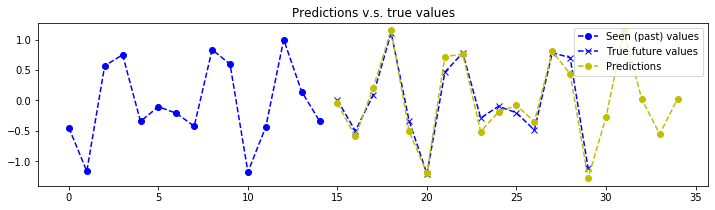

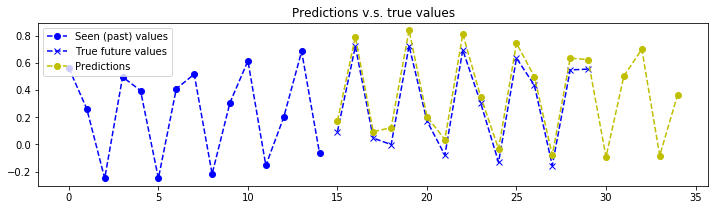

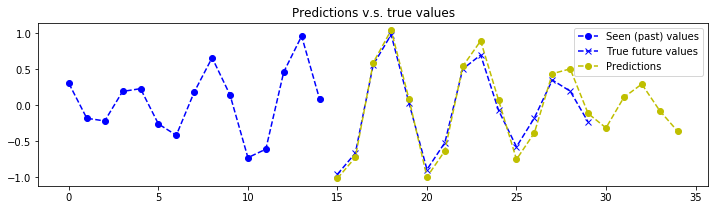

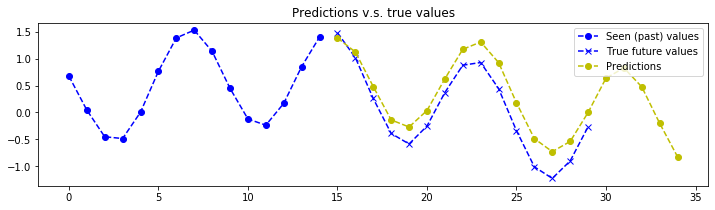

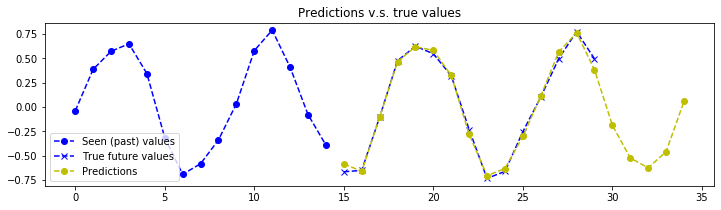

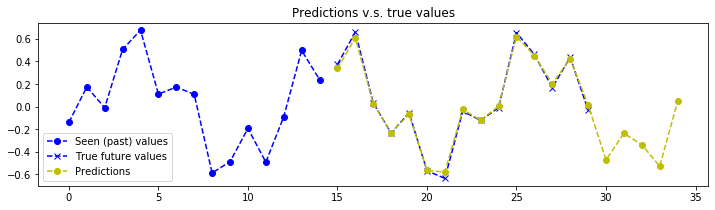

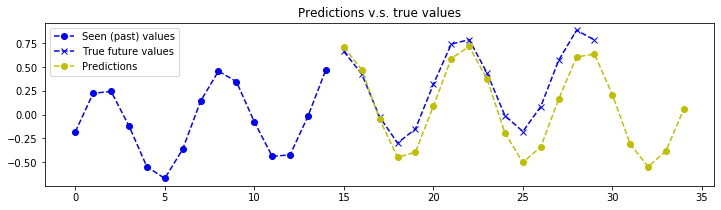

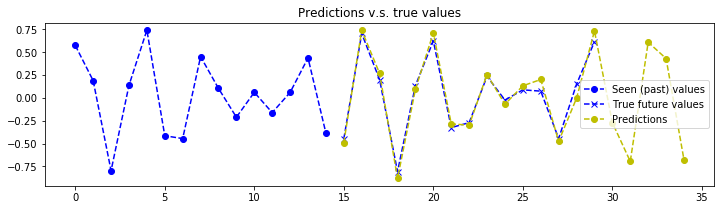

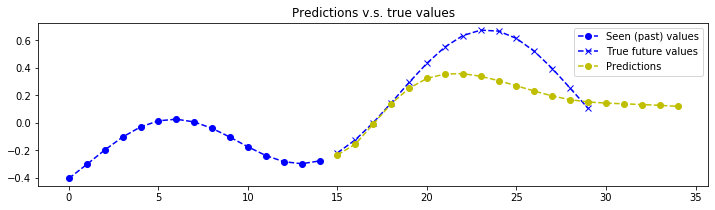

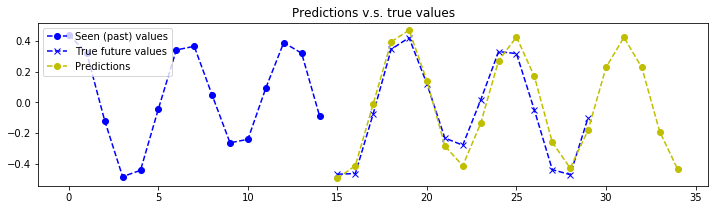

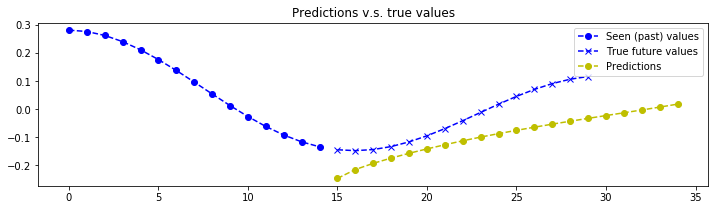

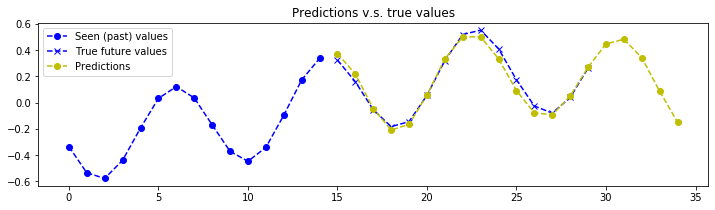

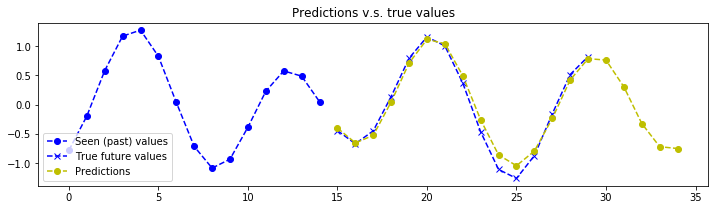

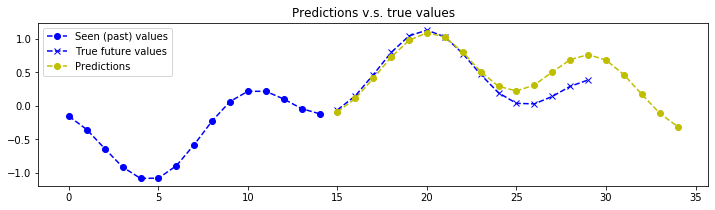

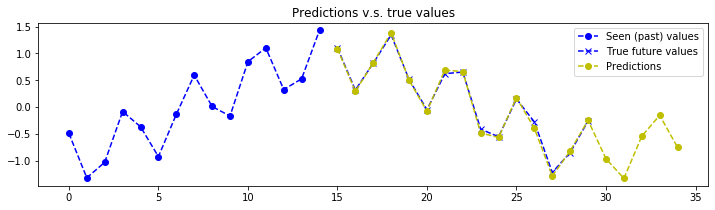

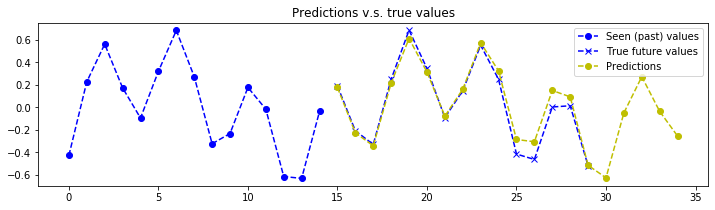

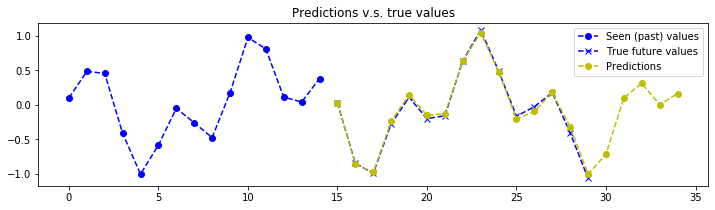

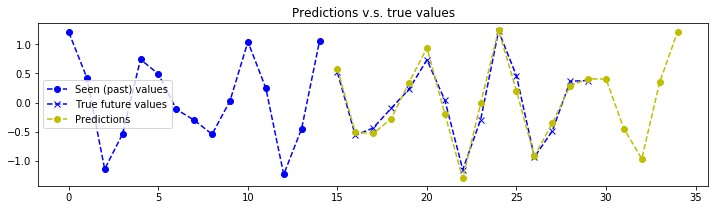

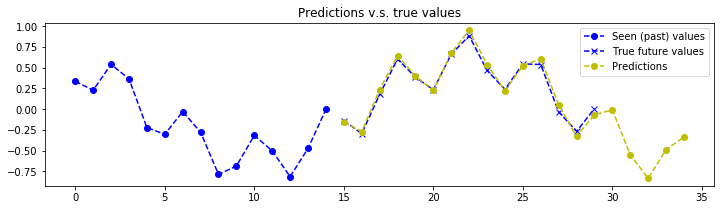

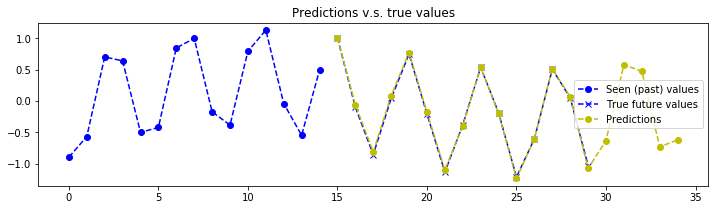

In [78]:

test_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=2000)

(x_encoder_test, x_decoder_test), y_test = next(test_data_generator) # x_decoder_test is composed of zeros.

y_test_predicted = model.predict([x_encoder_test, x_decoder_test])

encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

# Read layers backwards to fit the format of initial_state
# For some reason, the states of the model are order backwards (state of the first layer at the end of the list)
# If instead of a GRU you were using an LSTM Cell, you would have to append two Input tensors since the LSTM has 2 states.
for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

# The aim of this tutorial isn't to present how to evaluate the model or investigate the training.
# We could plot evaluation metrics such as RMSE over time, compare train and test batches for overfitting,
# produce validation and learning curves to analyse the effect of the number of epochs or training examples,
# have fun playing with tensorboard etc... We would need at least a whole other post for this.
# However, let's at least make sure that our model can predict correctly...
# Ask the generator to produce a batch of samples, don't forget to set the seed to something other than what was
# used for training or you will be testing on train data.
# The next function asks the generator to produce it's first batch.

test_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=2000)

(x_test, _), y_test = next(test_data_generator)

y_test_predicted = predict(x_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)

# Select 10 random examples to plot
indices = np.random.choice(range(x_test.shape[0]), replace=False, size=10)


for index in indices:
    plot_prediction(x_test[index, :, :], y_test[index, :, :], y_test_predicted[index, :, :])
    
# The model seems to struggle on very low wave signals. But that makes sense, the model doesn't see enough of the signal
# to make a good estimation of the frequency components.

train_data_generator = random_sine(batch_size=1000,
                                   steps_per_epoch=steps_per_epoch,
                                   input_sequence_length=input_sequence_length,
                                   target_sequence_length=target_sequence_length,
                                   min_frequency=0.1, max_frequency=10,
                                   min_amplitude=0.1, max_amplitude=1,
                                   min_offset=-0.5, max_offset=0.5,
                                   num_signals=num_signals, seed=1969)

(x_train, _), y_train = next(train_data_generator)

y_train_predicted = predict(x_train, encoder_predict_model, decoder_predict_model, num_steps_to_predict)

# Select 10 random examples to plot
indices = np.random.choice(range(x_train.shape[0]), replace=False, size=10)

for index in indices:
    plot_prediction(x_train[index, :, :], y_train[index, :, :], y_train_predicted[index, :, :])
    
    

1942 1512 252
lag  -5 0.17166829863944602
lag  -4 0.1730406246542056
lag  -3 0.1745084712767722
lag  -2 0.17595926368860224
lag  -1 0.17749337945673865
lag  0 0.17939494958136332
lag  1 0.1820333719068394
lag  2 0.18485214570971198
lag  3 0.18744457402683853
lag  4 0.19000971218903856
lag  5 0.19249761578953242


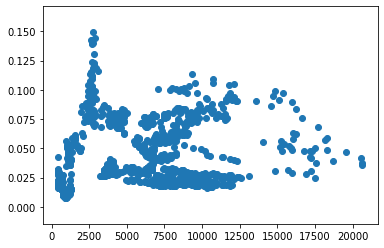

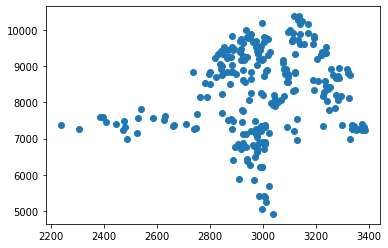

In [3]:
# correlation stock market - cryptocurr test 
import pandas as pd
import os
import matplotlib.pyplot as plt

def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

def crosscorr(datax, datay, lag=0):
    '''lag crosscorrelation'''
    return datax.corr(datay.shift(lag))

def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

os.chdir('D:\BernieData\DeepL\lrgtxt0')
# Read data from file 'filename.csv' 
# Control delimiters, rows, column names with read_csv (see later) 
spdata = pd.read_csv("SP500.csv")
ndqdata = pd.read_csv("nasdaq.csv")
btcdata = pd.read_csv("Cexio_BTCUSD_d.csv")
ethdata = pd.read_csv("Cexio_ETHBTC_d.csv")

# Preview the first 5 lines of the loaded data 
#spdata.head()
#btcdata.head()

#print(btcdata['Close'])
#s0 = spdata['Close']
#s1 = btcdata['Close']
#dcomb = {'sp500': spdata['Close'], 'btcusd': btcdata['Close']}
#df = pd.DataFrame(data=dcomb)

#s0.corr(s1, method=histogram_intersection)
#df_new = df_shifted(df, 'sp500', lag=-1)
#print(df_new)
print(len(btcdata['Close']), len(ethdata['Close']), len(spdata['Close']))
for lg in range(-5,6):
    #print('lag ', lg, crosscorr(ndqdata['Close'][0:100], ethdata['Close'][0:100], lg))
    #print('lag ', lg, crosscorr(ndqdata['Close'], ethdata['Close'], lg))
    print('lag ', lg, crosscorr(btcdata['Close'], ethdata['Close'], lg))
    
plt.scatter(btcdata['Close'][0:1512], ethdata['Close'][0:1512])
plt.show()
plt.scatter(spdata['Close'][0:252], btcdata['Close'][0:252])
plt.show()

In [65]:
print(btcdata['Close'][0:5])

encdec_din = btcdata['Close'][0:1512]
print('# of unique values: ', len(set(encdec_din)))

# split data into n classes
nclasses = 50
v_min = np.min(encdec_din)
v_max = np.max(encdec_din)
dlta = (v_max - v_min) / nclasses
print('value: ', encdec_din[100], ' class: ', int((encdec_din[100] - v_min) / dlta))
print('value: ', encdec_din[150], ' class: ', int((encdec_din[150] - v_min) / dlta))
print('value: ', encdec_din[500], ' class: ', int((encdec_din[500] - v_min) / dlta))

0    9441.4
1    9475.7
2    9468.0
3    9280.2
4    9897.9
Name: Close, dtype: float64
# of unique values:  1504
value:  9159.7  class:  21
value:  8747.1  class:  20
value:  3738.5  class:  8


In [5]:
# NN embedding test 0
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

# load the dataset
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
dataset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# split into input (X) and output (y) variables
#X = dataset[:,0:8] # select the first 8 columns from index 0 to index 7
#y = dataset[:,8] # select the output column (the 9th variable) via index 8
X = dataset
y = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

clear_session()

# define the keras model
model = Sequential()
#model.add(Dense(12, input_dim=8, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1, input_dim=1, activation='relu'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X, y, epochs=5, batch_size=1)

# evaluate the keras model
_, accuracy = model.evaluate(X, y)

print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/5
10/10 [==============================] - 3s 314ms/step - loss: 9.2334 - accuracy: 0.1000
Epoch 2/5
10/10 [==============================] - 0s 5ms/step - loss: 8.2987 - accuracy: 0.1000 
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: 8.1954 - accuracy: 0.1000    
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 8.1822 - accuracy: 0.1000    
Epoch 5/5
10/10 [==============================] - 0s 5ms/step
Accuracy: 10.00


In [8]:
# NN embedding test 1
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

# load the dataset
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
dataset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# split into input (X) and output (y) variables
#X = dataset[:,0:8] # select the first 8 columns from index 0 to index 7
#y = dataset[:,8] # select the output column (the 9th variable) via index 8
X = np.array([[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4]]) # input shape: (batch_size, input_dim)
#X = [list(range(10)) for _ in range(10)]
y = np.array([[1], [1], [1], [0], [0]]) # output shape: (batch_size, units)
#print(np.shape(X), np.shape(y))

clear_session()

# define the keras model
model = Sequential()
#model.add(Dense(12, input_dim=8, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(5, input_dim=5, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='relu'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X, y, epochs=5, batch_size=1)

# evaluate the keras model
_, accuracy = model.evaluate(X, y)

print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/5
5/5 [==============================] - 0s 24ms/step - loss: 9.2550 - accuracy: 0.4000
Epoch 2/5
5/5 [==============================] - 0s 5ms/step - loss: 9.2550 - accuracy: 0.4000 
Epoch 3/5
5/5 [==============================] - 0s 5ms/step - loss: 9.2550 - accuracy: 0.4000
Epoch 4/5
5/5 [==============================] - 0s 3ms/step - loss: 9.2550 - accuracy: 0.4000
Epoch 5/5
5/5 [==============================] - 0s 5ms/step
Accuracy: 40.00


In [13]:
# NN embedding test 2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

# input X and target y
#X = encdec_din # time series input
#y = encdec_din # same as X - autoencode
X = np.array([encdec_din[i:i+5] for i in range(len(encdec_din)-5)])
#y = np.array([[1] for i in range(len(encdec_din)-5)])
y = np.array([np.average(encdec_din[i:i+5]) for i in range(len(encdec_din)-5)])

clear_session()

# define the keras model
model = Sequential()
#model.add(Dense(12, input_dim=8, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(3, input_dim=5, activation='relu')) # input with 5 variables and 3 nodes
model.add(Dense(50, activation='relu'))
#model.add(Dense(1, activation='relu'))
model.add(Dense(1, activation='relu'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X, y, epochs=5, batch_size=1)

# evaluate the keras model
_, accuracy = model.evaluate(X, y)

print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/5
1507/1507 [==============================] - 4s 3ms/step - loss: 87058.7169 - accuracy: 0.0000e+00
Epoch 2/5
1507/1507 [==============================] - 4s 3ms/step - loss: 87058.7169 - accuracy: 0.0000e+00
Epoch 3/5
1507/1507 [==============================] - 4s 3ms/step - loss: 87058.7169 - accuracy: 0.0000e+00
Epoch 4/5
1507/1507 [==============================] - 4s 3ms/step - loss: 87058.7169 - accuracy: 0.0000e+00
Epoch 5/5
1507/1507 [==============================] - 0s 53us/step
Accuracy: 0.00


In [62]:
# make a prediction
Xnew = np.array([[1500, 1500, 1500, 1000, 1000]])
ynew = model.predict(Xnew)
print(ynew)
Xnew = np.array([[0, 0, 1500, 0, 0]])
ynew = model.predict(Xnew)
print(ynew)
Xnew = np.array([[9441.4, 8500.4, 1.4, 9441.4, 2.4]])
ynew = model.predict(Xnew)
print(ynew)

[[0.]]
[[15.651303]]
[[311.61224]]


In [70]:
# enc-dec with attention 2nd type - use pandas loaded data

from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import GRU # LSTM
#from attention_decoder import AttentionDecoder
import numpy as np

def gen_vocab(dt_in):
    '''create vocabulary from data'''
    vsetl = list(set(dt_in))
    return {vsetl[i]:i for i in range(len(vsetl))}

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]

# generate a sequence of integers from data
def gen_seq_data(dt_in, v_in):
    return [v_in[delm] for delm in dt_in]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality, dt_in, v_in, rnd=True):
    if rnd:
        # generate random sequence
        sequence_in = generate_sequence(n_in, cardinality)
    else:
        sequence_in = gen_seq_data(dt_in, v_in)
        cardinality = len(set(dt_in))
    sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
    # one hot encode
    print(sequence_in, sequence_out, cardinality)
    X = one_hot_encode(sequence_in, cardinality)
    y = one_hot_encode(sequence_out, cardinality)
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y

def gen_classeq(dt_in, ncl):
    '''split data into n classes'''
    v_min = np.min(dt_in)
    v_max = np.max(dt_in)
    dlta = (v_max - v_min) / ncl
    return [int((dtel-v_min)/dlta) for dtel in dt_in]

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_epochs = 100

# data classes
edt_cl = gen_classeq(encdec_din, n_features)

# define model
model = Sequential()
#model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
model.add(GRU(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
model.add(AttentionQKVDecoder(150, n_features))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# create data vocabulary
v_in = gen_vocab(edt_cl)

# train LSTM
for epoch in range(n_epochs):
    # generate new random sequence
    #X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features, edt_cl[epoch:epoch+5], v_in, False)
    # fit model for one epoch on this sequence
    #model.fit(X, y, epochs=1, verbose=2)
    if epoch % 100 == 0:
        model.fit(X, y, epochs=1, verbose=2) # verbose=2 full details (1: progress bar)
    else:
        model.fit(X, y, epochs=1, verbose=0) # verbose=0 is silent
    
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
    #X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features, edt_cl[0:5], v_in, False)
    yhat = model.predict(X, verbose=0)
    if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

# spot check some examples
for _ in range(10):
    #X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features, edt_cl[0:5], v_in, False)
    yhat = model.predict(X, verbose=0)
    print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))

[22, 22, 22, 21, 23] [22, 22, 0, 0, 0] 3


IndexError: list assignment index out of range

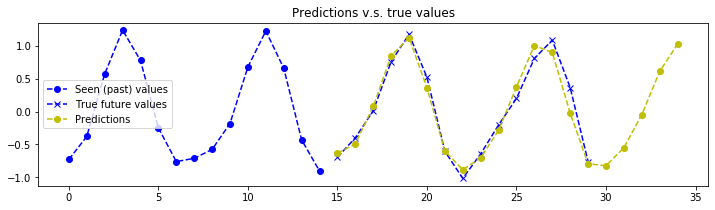

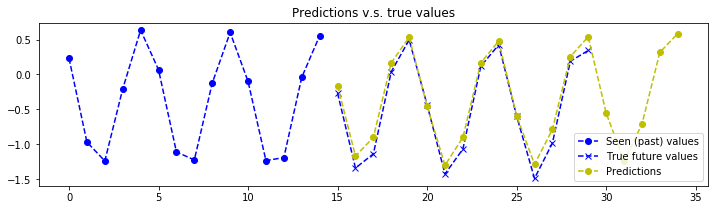

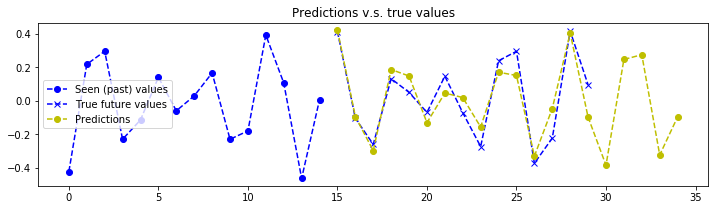

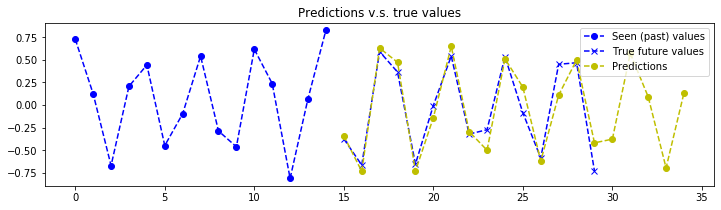

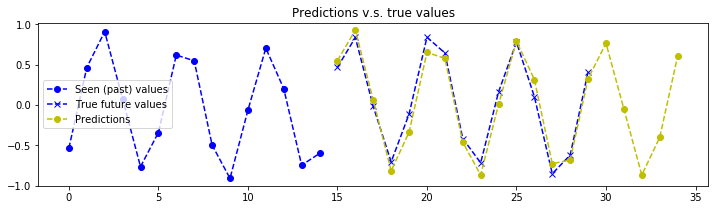

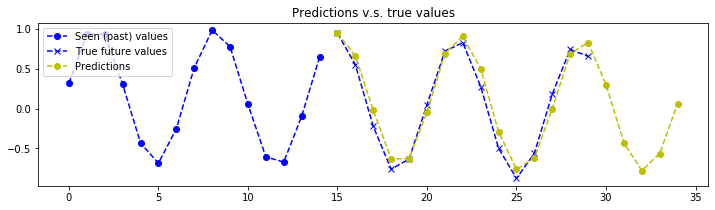

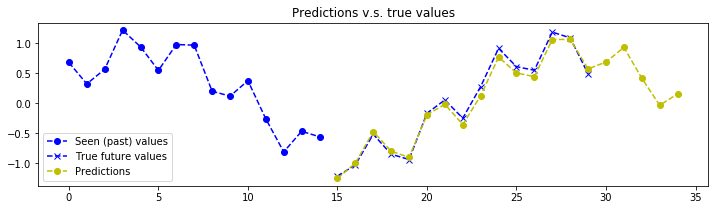

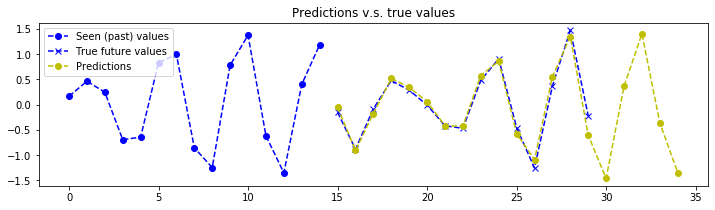

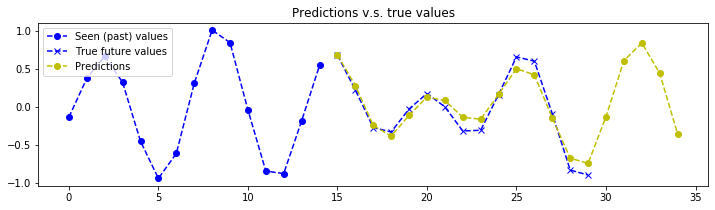

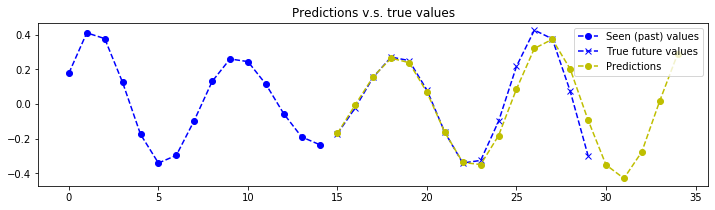

In [79]:
# apply prediction to market data

test_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=2000)

(x_encoder_test, x_decoder_test), y_test = next(test_data_generator) # x_decoder_test is composed of zeros.

y_test_predicted = model.predict([x_encoder_test, x_decoder_test])

encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

# Read layers backwards to fit the format of initial_state
# For some reason, the states of the model are order backwards (state of the first layer at the end of the list)
# If instead of a GRU you were using an LSTM Cell, you would have to append two Input tensors since the LSTM has 2 states.
for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))

    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

# The aim of this tutorial isn't to present how to evaluate the model or investigate the training.
# We could plot evaluation metrics such as RMSE over time, compare train and test batches for overfitting,
# produce validation and learning curves to analyse the effect of the number of epochs or training examples,
# have fun playing with tensorboard etc... We would need at least a whole other post for this.
# However, let's at least make sure that our model can predict correctly...
# Ask the generator to produce a batch of samples, don't forget to set the seed to something other than what was
# used for training or you will be testing on train data.
# The next function asks the generator to produce it's first batch.

test_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=2000)

(x_test, _), y_test = next(test_data_generator)

y_test_predicted = predict(x_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)

# Select 10 random examples to plot
indices = np.random.choice(range(x_test.shape[0]), replace=False, size=10)

for index in indices:
    plot_prediction(x_train[index, :, :], y_train[index, :, :], y_train_predicted[index, :, :])
    

In [58]:
# factorial numbers
import math

def tofact(n):
    '''convert n to factorial base'''
    #return [((n - int(i*(i+1)/2)) % i, i) for i in range(int(math.sqrt(n-1)), 0, -1)]
    res = []
    for p in range(int((1+math.sqrt(1+4*math.log(n)))), 0, -1):
        pval = p**(p-1)
        res.append((n // pval, p))
        n %= pval
    return res

n = 13
print(tofact(n))
n = 123
print(tofact(n))
n = 1234
print(tofact(n))

[(0, 4), (1, 3), (2, 2), (0, 1)]
[(0, 5), (1, 4), (6, 3), (2, 2), (1, 1)]
[(0, 6), (1, 5), (9, 4), (3, 3), (3, 2), (0, 1)]
